# Numerical Methods

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
warnings.filterwarnings("ignore")

## Univariate Setting

In [7]:
def payoff(S, K, is_call):
    if is_call:
        out = np.maximum(S - K, 0)
    else:
        out = np.maximum(K - S, 0)

    return out


def black_scholes_naive_implicit(N, M, Smin, Smax, T, K, volatility, r, d, is_call):
    surf = np.zeros((1+N, 1+M))
    dt = T/N
    dS = (Smax-Smin)/M
    t_vals = np.arange(0, T+dt, dt)
    S_vals = np.arange(Smin, Smax+dS, dS)

    if is_call:
        surf[:, 0] = 0
        surf[:, -1] = Smax - K
        surf[-1, :] = payoff(S_vals, K, is_call)
    else:
        surf[:, 0] = K
        surf[:, -1] = 0
        surf[-1, :] = payoff(S_vals, K, is_call)

    a = lambda j: 0.5*(r-d)*j*dt - 0.5*volatility**2*j**2*dt
    b = lambda j: 1 + volatility**2*j**2*dt + r*dt
    c = lambda j: -0.5*(r-d)*j*dt - 0.5*volatility**2*j**2*dt

    for i in range(N-1, -1, -1):
        A = np.diag(a(np.arange(1, M)), -1) + np.diag(b(np.arange(1, M+1))) + np.diag(c(np.arange(1, M)), 1)
        v = surf[i+1, 1:M+1].T
        v[0] -= a(1)*surf[i, 0]
        v[-1] -= c(M)*surf[i, M]
        surf[i, 1:M+1] = np.linalg.solve(A, v)
        surf[i, 1:M+1] = np.maximum(surf[i, 1:M+1], payoff(S_vals[1:M+1], K, is_call))

    return t_vals, S_vals, surf


def black_scholes_naive_explicit(N, M, Smin, Smax, T, K, volatility, r, d, is_call):
    # Create an empty surface
    surf = np.zeros((1+N, 1+M))

    # Determine differentials
    dt = T/N
    dS = (Smax - Smin)/M

    # Create grid mesh
    t_vals = np.linspace(0, T, N+1)
    S_vals = np.linspace(Smin, Smax, M+1)

    # Set boundary conditions
    if is_call:
        surf[:, 0] = 0
        surf[:, -1] = Smax - K
        surf[-1, :] = payoff(S_vals, K, is_call)
    else:
        surf[:, 0] = K
        surf[:, -1] = 0
        surf[-1, :] = payoff(S_vals, K, is_call)

    # Compute remaining values
    a = lambda j: 1/(1 + r*dt) * (-0.5*(r-d)*j*dt + 0.5*volatility**2*j**2*dt)
    b = lambda j: 1/(1 + r*dt) * (1 - volatility**2*j**2*dt)
    c = lambda j: 1/(1 + r*dt) * (0.5*(r-d)*j*dt + 0.5*volatility**2*j**2*dt)

    for i in range(N-1, -1, -1):
        A = np.diag(a(np.arange(2, M)), -1) + np.diag(b(np.arange(2, M+1))) + np.diag(c(np.arange(1, M-1)), 1)
        for j in range(1, M):  # Adjust loop range
            surf[i, j] = a(j)*surf[i+1, j-1] + b(j)*surf[i+1, j] + c(j)*surf[i+1, j+1]

        # Enforce free boundary condition
        surf[i, 1:M] = np.maximum(surf[i, 1:M], payoff(S_vals[1:M], K, is_call))

    return t_vals, S_vals, surf



def black_scholes_cov_explicit(N, M, Smin, Smax, T, K, volatility, r, d, is_call):
    # Create an empty surface
    surface = np.zeros((1+N, 1+M))

    # Change of variables: tau and x
    tauMax = (volatility**2 * T) / 2
    dtau = tauMax / N
    tau_vals = np.arange(0, tauMax + dtau, dtau)

    xMax = np.log(Smax / K)
    xMin = np.log(Smin / K)
    dx = (xMax - xMin) / M
    x_vals = np.arange(xMin, xMax + dx, dx)

    k = r / (volatility**2 / 2)
    kprime = (r - d) / (volatility**2 / 2)
    alpha = -0.5 * (kprime - 1)
    beta = -0.25 * (kprime - 1)**2 - k

    g = lambda x, tau: np.exp((0.25 * (kprime - 1)**2 + k) * tau) * \
        np.maximum(np.exp(0.5 * (kprime + 1) * x) - np.exp(0.5 * (kprime - 1) * x), 0)

    t_vals = T - 2 * tau_vals / (volatility**2)
    S_vals = K * np.exp(x_vals)

    s = dtau / (dx**2)
    print('s is', s, '(must be <= 0.5)')

    # Set boundary conditions
    if is_call:
        surface[:, 0] = 0
        surface[:, -1] = g(xMax, tau_vals)
        surface[0, :] = g(x_vals, 0)
    else:
        surface[:, 0] = 0
        surface[:, -1] = K
        surface[0, :] = payoff(S_vals, K, is_call)

    # Compute remaining values
    for i in range(1, N+1):
        for j in range(1, M):
            surface[i, j] = s * surface[i-1, j-1] + (1 - 2*s) * surface[i-1, j] + s * surface[i-1, j+1]

        # Enforce free boundary condition
        surface[i, 1:M] = np.maximum(surface[i, 1:M], g(x_vals[1:M], tau_vals[i]))

    # Transform surface values of u back into option price
    mesh_x, mesh_tau = np.meshgrid(x_vals, tau_vals)
    surface = K * np.exp(alpha * mesh_x + beta * mesh_tau) * surface

    return t_vals, S_vals, surface


def black_scholes_crank_nicolson(N, M, Smin, Smax, T, K, volatility, r, d, is_call):
    surf = np.zeros((1+N, 1+M))
    dt = T/N
    dS = (Smax-Smin)/M
    t_vals = np.arange(0, T+dt, dt)
    S_vals = np.arange(Smin, Smax+dS, dS)

    if is_call:
        surf[:, 0] = 0
        surf[:, -1] = Smax - K
        surf[-1, :] = payoff(S_vals, K, is_call)
    else:
        surf[:, 0] = K
        surf[:, -1] = 0
        surf[-1, :] = payoff(S_vals, K, is_call)

    for i in range(N-1, -1, -1):
        a = -0.25 * (r - d) * dt * np.arange(1, M)
        b = 1 + 0.5 * (r - d) * dt * np.arange(1, M+1)
        c = -0.25 * (r - d) * dt * np.arange(1, M)

        A = np.diag(a, -1) + np.diag(b) + np.diag(c, 1)

        v = surf[i+1, 1:M+1].T
        v[0] -= -0.25 * (r - d) * dt * surf[i, 0]
        v[-1] -= -0.25 * (r - d) * dt * surf[i, M]

        A = A[1:M, 1:M]  # Keep only the square part of A
        v = v[0:M-1]

        surf[i, 1:M] = np.linalg.solve(A, v)
        surf[i, 1:M] = np.maximum(surf[i, 1:M], payoff(S_vals[1:M], K, is_call))

    return t_vals, S_vals, surf


def plot_single_asset(t_vals, S_vals, surf, K, T, title='Explicit Euler'):
    # Set values for plot
    S_check = np.linspace(0, 1.5 * K, 20)
    t_check = np.linspace(0, T, 20)
    surf_check = np.zeros((len(t_check), len(S_check)))

    # Interpolate values for plot
    for i in range(len(t_check)):
        for j in range(len(S_check)):
            surf_check[i, j] = interp2d(S_vals, t_vals, surf)(S_check[j], t_check[i])

    # Create a 3D plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    S_checks, t_checks = np.meshgrid(S_check, np.flip(t_check))
    ax.plot_surface(S_checks, np.flip(t_checks), surf_check, cmap='viridis')
    ax.grid(False)  # Remove the grid

    # Set labels and title
    ax.set_xlabel('Stock Price')
    ax.set_ylabel('Time Until Maturity')
    ax.set_zlabel('Option Price')
    ax.set_title(title)

    ax.view_init(elev=20, azim=120)

    # Show the plot
    plt.show()

    # Interpolate a single point and display it
    S_check = 30
    t_check = 0.25
    point = interp2d(S_vals, t_vals, surf)(S_check, t_check)
    print(f"At S={S_check} and t={t_check}, option price is {point}, for {title}")

### Problem formulation

In [8]:
# Example usage
N = 100
M = 100
Smin = 0.4
Smax = 1000
T = 1
K = 100
volatility = 0.2
r = 0.02
d = 0
is_call = True

### Implicit Euler

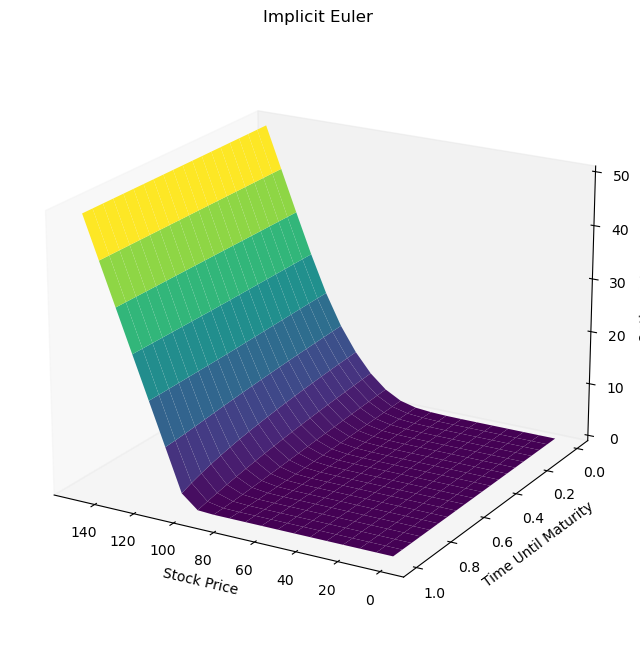

At S=30 and t=0.25, option price is [1.86112815e-06], for Implicit Euler


In [9]:
t_vals, S_vals, surf = black_scholes_naive_implicit(N, M, Smin, Smax, T, K, volatility, r, d, is_call)
plot_single_asset(t_vals, S_vals, surf, K, T, title='Implicit Euler')

### Explicit Euler

s is 0.0326713593300246 (must be <= 0.5)


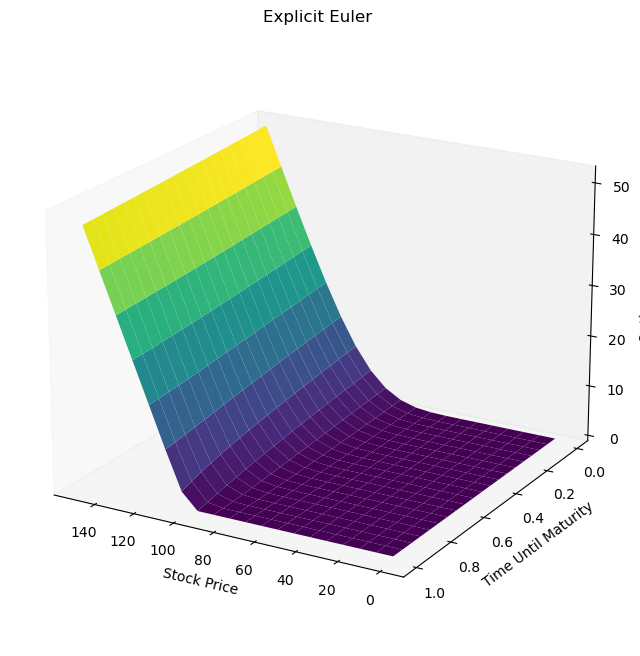

At S=30 and t=0.25, option price is [3.8810981e-09], for Explicit Euler


In [10]:
t_vals, S_vals, surf = black_scholes_cov_explicit(N, M, Smin, Smax, T, K, volatility, r, d, is_call)
plot_single_asset(t_vals, S_vals, surf, K, T, title='Explicit Euler')

### Crank-Nicolson

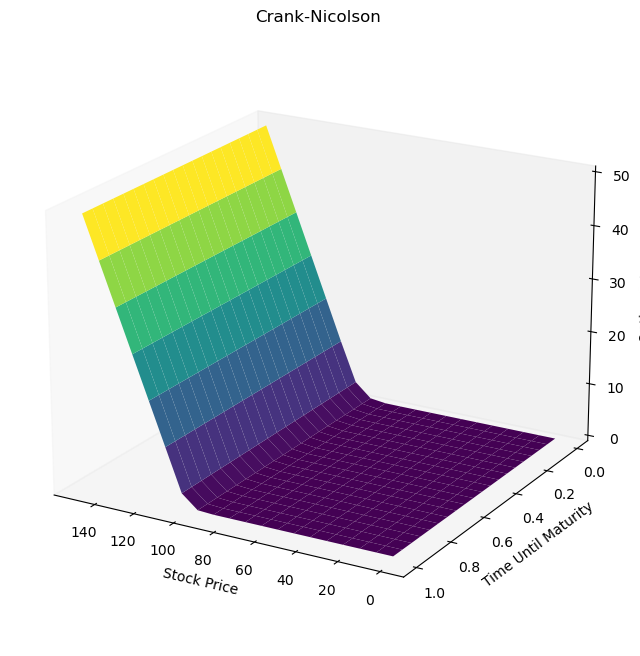

At S=30 and t=0.25, option price is [6.21961147e-16], for Crank-Nicolson


In [11]:
t_vals, S_vals, surf = black_scholes_crank_nicolson(N, M, Smin, Smax, T, K, volatility, r, d, is_call)
plot_single_asset(t_vals, S_vals, surf, K, T, title='Crank-Nicolson')

## Multivariate Setting

In [13]:
def black_scholes_implicit_multi_asset(N, M, Smin, Smax, T, K, volatilities, r, d, is_call):
    num_assets = len(volatilities)
    surf = np.zeros((1 + N, num_assets, 1 + M))
    dt = T / N
    dS = (Smax - Smin) / M
    t_vals = np.arange(0, T + dt, dt)
    S_vals = np.arange(Smin, Smax + dS, dS)

    for asset_idx in range(num_assets):
        if is_call:
            surf[:, asset_idx, 0] = 0
            surf[:, asset_idx, -1] = Smax - K[asset_idx]
            surf[-1, asset_idx, :] = payoff(S_vals, K[asset_idx], is_call)
        else:
            surf[:, asset_idx, 0] = K[asset_idx]
            surf[:, asset_idx, -1] = 0
            surf[-1, asset_idx, :] = payoff(S_vals, K[asset_idx], is_call)

    a = lambda j, asset_idx: 0.5 * (r - d) * j * dt - 0.5 * volatilities[asset_idx] ** 2 * j ** 2 * dt
    b = lambda j, asset_idx: 1 + volatilities[asset_idx] ** 2 * j ** 2 * dt + r * dt
    c = lambda j, asset_idx: -0.5 * (r - d) * j * dt - 0.5 * volatilities[asset_idx] ** 2 * j ** 2 * dt

    for i in range(N - 1, -1, -1):
        for asset_idx in range(num_assets):
            A = np.diag(a(np.arange(1, M), asset_idx), -1) + np.diag(b(np.arange(1, M + 1), asset_idx)) + np.diag(c(np.arange(1, M), asset_idx), 1)
            v = surf[i + 1, asset_idx, 1:M + 1].T
            v[0] -= a(1, asset_idx) * surf[i, asset_idx, 0]
            v[-1] -= c(M, asset_idx) * surf[i, asset_idx, M]
            surf[i, asset_idx, 1:M + 1] = np.linalg.solve(A, v)
            surf[i, asset_idx, 1:M + 1] = np.maximum(surf[i, asset_idx, 1:M + 1], payoff(S_vals[1:M + 1], K[asset_idx], is_call))

    return t_vals, S_vals, surf



def black_scholes_crank_nicolson_multi_asset(N, M, Smin, Smax, T, K, volatilities, r, d, is_call):
    num_assets = len(volatilities)
    surf = np.zeros((1 + N, num_assets, 1 + M))
    dt = T / N
    dS = (Smax - Smin) / M
    t_vals = np.arange(0, T + dt, dt)
    S_vals = np.arange(Smin, Smax + dS, dS)

    for asset_idx in range(num_assets):
        if is_call:
            surf[:, asset_idx, 0] = 0
            surf[:, asset_idx, -1] = Smax - K[asset_idx]
            surf[-1, asset_idx, :] = payoff(S_vals, K[asset_idx], is_call)
        else:
            surf[:, asset_idx, 0] = K[asset_idx]
            surf[:, asset_idx, -1] = 0
            surf[-1, asset_idx, :] = payoff(S_vals, K[asset_idx], is_call)

    for i in range(N - 1, -1, -1):
        for asset_idx in range(num_assets):
            a = -0.25 * dt * (r - d) * np.arange(1, M)
            b = 1 + 0.5 * dt * (r + volatilities[asset_idx]**2) * np.arange(1, M + 1)
            c = -0.25 * dt * (r - d) * np.arange(1, M)

            A = np.diag(a, -1) + np.diag(b) + np.diag(c, 1)

            v = surf[i + 1, asset_idx, 1:M + 1].T
            v[0] -= 0.25 * dt * (r - d) * surf[i, asset_idx, 0]
            v[-1] -= 0.25 * dt * (r - d) * surf[i, asset_idx, M]

            surf[i, asset_idx, 1:M + 1] = np.linalg.solve(A, v)
            surf[i, asset_idx, 1:M + 1] = np.maximum(surf[i, asset_idx, 1:M + 1], payoff(S_vals[1:M + 1], K[asset_idx], is_call))

    return t_vals, S_vals, surf



def plot_multi_asset(t_vals, S_vals, surf, K, title="Implicit Euler"):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(False)  


    # Plot the surface for each asset
    for asset_idx in range(len(K)):
        S_check = np.linspace(0, 1.5 * K[asset_idx], 20)
        t_check = np.linspace(0, T, 20)
        surf_check = np.zeros((len(t_check), len(K), len(S_check)))

        # Interpolate values for plot
        for i in range(len(t_check)):
            for j in range(len(S_check)):
                surf_check[i, asset_idx, j] = interp2d(S_vals, t_vals, surf[:, asset_idx, :])(S_check[j], t_check[i])

        S_checks, t_checks = np.meshgrid(S_check, np.flip(t_check))
        ax.plot_surface(S_checks, t_checks, surf_check[:, asset_idx, :], label=f'Asset {asset_idx + 1}', cmap='viridis')

    # Set labels and legend
    ax.set_xlabel('Stock Price')
    ax.set_ylabel('Time Until Maturity')
    ax.set_zlabel('Option Price')
    ax.set_title(title)
    ax.view_init(elev=20, azim=120)

    plt.show()

def plot_multi_asset_combined(t_vals, S_vals, surf, K, T, N, M, title="Multi-asset solution Implicit Euler"):
    # Extract the data for plotting
    t_check = np.linspace(0, T, N+1)  # Time values
    S1_vals = np.linspace(0, 1.5 * K[0], M+1)  # Asset 1 prices
    S2_vals = np.linspace(0, 1.5 * K[1], M+1)  # Asset 2 prices

    # Create a meshgrid for 3D plotting
    T, S1 = np.meshgrid(t_check, S1_vals)
    _, S2 = np.meshgrid(t_check, S2_vals)

    surf_check = np.zeros((len(t_check), len(K), len(S1_vals)))

    # Create a 3D plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    for i in range(len(t_check)):
        for j in range(len(S1_vals)):
            surf_check[i, 0, j] = interp2d(S_vals, t_vals, surf[:, 0, :])(S1_vals[j], t_check[i])

    surf_plot = ax.plot_surface(S1, S2, surf_check[:, 0, :], cmap='viridis')

    # Set labels and title
    ax.set_xlabel('Asset 1 Price (S1)')
    ax.set_ylabel('Asset 2 Price (S2)')
    ax.set_zlabel('Option Price')
    ax.set_title(title)
    ax.grid(False)  # Remove the grid

    # Add a colorbar
    fig.colorbar(surf_plot, ax=ax, shrink=0.5, aspect=8)

    # Show the plot
    plt.show()
    return surf_check[:, 0, :]




def plot_multi_asset_combined_ml(t_vals, S_vals, surf, K, T, N, M, title="PINO Solution"):
    # Extract the data for plotting
    t_check = np.linspace(0, T, N+1)  # Time values
    S1_vals = np.linspace(0, 1.7 * K[0], M+1)  # Asset 1 prices
    S2_vals = np.linspace(0, 1.7 * K[1], M+1)  # Asset 2 prices

    # Create a meshgrid for 3D plotting
    T, S1 = np.meshgrid(t_vals, S1_vals)
    _, S2 = np.meshgrid(t_vals, S2_vals)

    surf_check = np.zeros((len(t_check), len(K), len(S1_vals)))

    # Create a 3D plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    for i in range(len(t_vals)):
        for j in range(len(S1_vals)):
            surf_check[i, 0, j] = interp2d(S_vals, t_vals, surf[:, 0, :])(S1_vals[j], t_check[i])

    surf_plot = ax.plot_surface(S1, S2, surf_check[:, 0, :], cmap='viridis')

    # Set labels and title
    ax.set_xlabel('Asset 1 Price (S1)')
    ax.set_ylabel('Asset 2 Price (S2)')
    ax.set_zlabel('Option Price')
    ax.set_title(title)
    ax.grid(False)  # Remove the grid

    # Add a colorbar
    fig.colorbar(surf_plot, ax=ax, shrink=0.5, aspect=8)

    # Show the plot
    plt.show()
    return surf_check[:, 0, :] / 20


def plot_single_timepoint_ml(t_vals, S_vals, surf, K, T, N, M, time_point, title="PINO Solution"):
    # Extract the data for the specified time point
    t_check = np.linspace(0, T, N+1)  # Time values
    S1_vals = np.linspace(0, 1.7 * K[0], M+1)  # Asset 1 prices
    S2_vals = np.linspace(0, 1.7 * K[1], M+1)  # Asset 2 prices

    # Find the index corresponding to the specified time point
    time_index = np.argmin(np.abs(t_vals - time_point))

    # Create a meshgrid for 3D plotting
    T, S1 = np.meshgrid(t_vals, S1_vals)
    _, S2 = np.meshgrid(t_vals, S2_vals)

    surf_check = np.zeros((len(t_check), len(K), len(S1_vals)))

    # Create a 3D plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface for the specified time point
    for j in range(len(S1_vals)):
        surf_check[:, 0, j] = np.squeeze(interp2d(S_vals, t_vals, surf[:, 0, :])(S1_vals[j], t_check))
    
    surf_plot = ax.plot_surface(S1, S2, surf_check[:, 0, :], cmap='viridis')

    # Set labels and title
    ax.set_xlabel('Asset 1 Price (S1)')
    ax.set_ylabel('Asset 2 Price (S2)')
    ax.set_zlabel('Option Price')
    ax.set_title(title + f' at Time Point {time_point}')
    ax.grid(False)  # Remove the grid

    # Add a colorbar
    fig.colorbar(surf_plot, ax=ax, shrink=0.5, aspect=8)

    # Show the plot
    plt.show()
    return surf_check[:, 0, :] / 20

# Example usage:
# Specify the desired time point (e.g., 0.5)
time_point_to_plot = 0.5
result_data = plot_single_timepoint_ml(t_vals, S_vals, surf, K, T, N, M, time_point_to_plot)


TypeError: 'int' object is not subscriptable

### Problem formulation

In [14]:
# Example usage and results
N = 100
M = 100
Smin = 0.4
Smax = 1000
T = 1.0
K = [100, 110]  # Example strike prices for two assets
volatilities = [0.2, 0.3]  # Example volatilities for two assets
r = 0.02
d = 0.2
is_call = True

### Implicit Euler

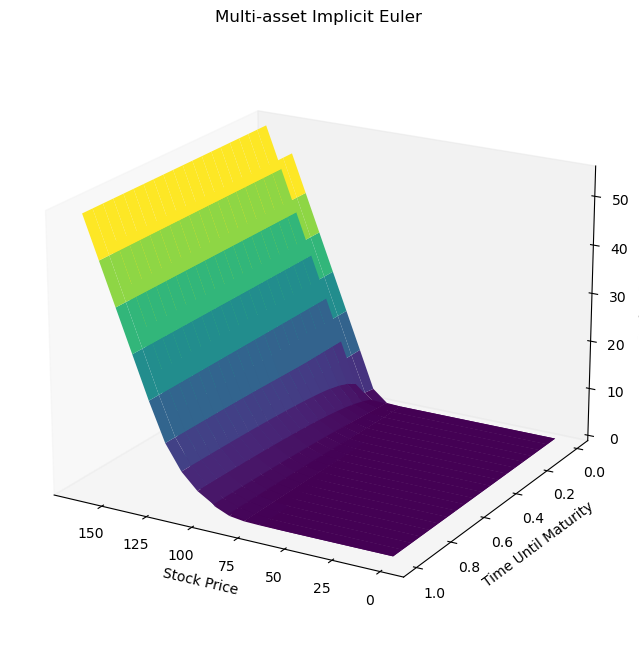

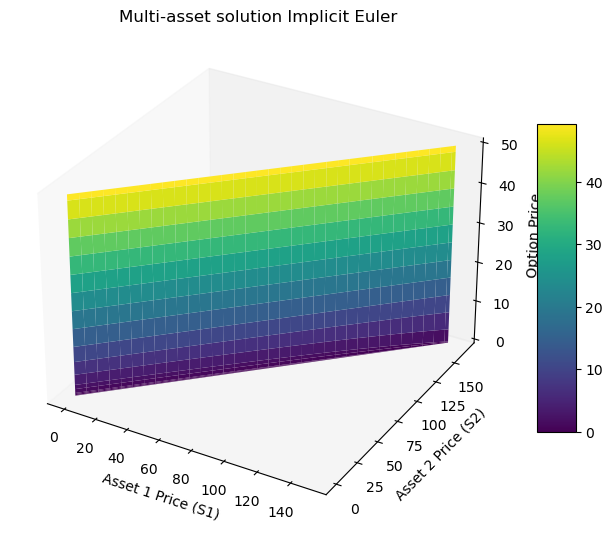

In [ ]:
t_vals, S_vals, surf = black_scholes_implicit_multi_asset(N, M, Smin, Smax, T, K, volatilities, r, d, is_call)
plot_multi_asset(t_vals, S_vals, surf, K, title="Multi-asset Implicit Euler")
# res_imp  = plot_multi_asset_combined(t_vals, S_vals, surf, K, T, N, M, title="Multi-asset solution Implicit Euler")

### Crank-Nicolson

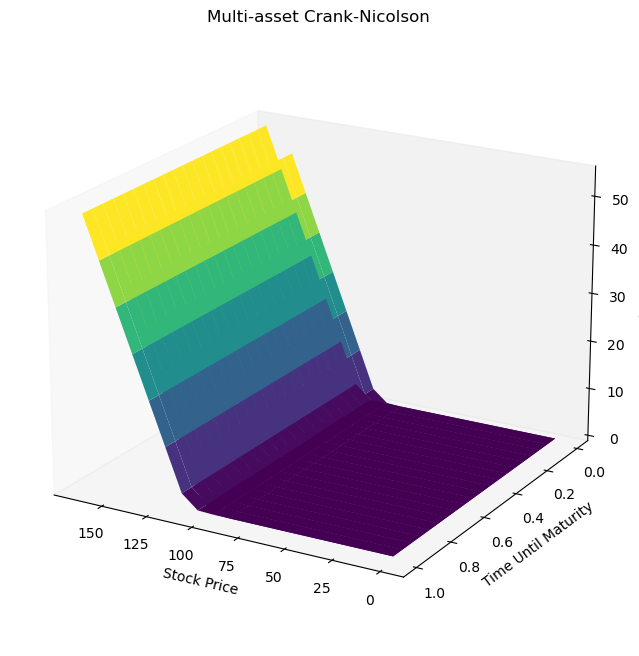

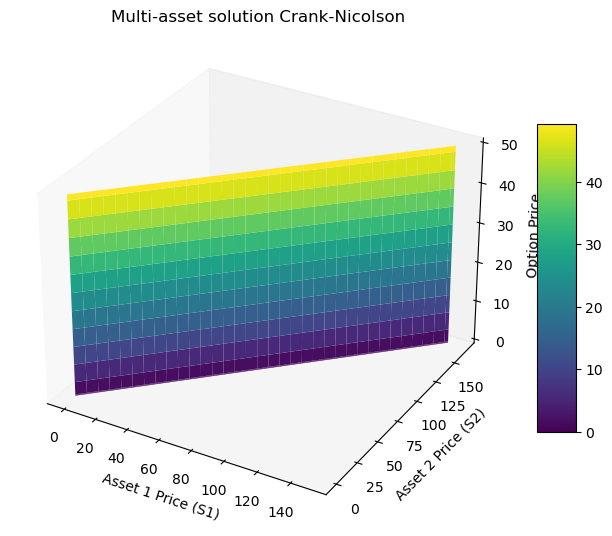

In [ ]:
t_vals, S_vals, surf = black_scholes_crank_nicolson_multi_asset(N, M, Smin, Smax, T, K, volatilities, r, d, is_call)

plot_multi_asset(t_vals, S_vals, surf, K, title="Multi-asset Crank-Nicolson")
# res_cn = plot_multi_asset_combined(t_vals, S_vals, surf, K, T, N, M, title="Multi-asset solution Crank-Nicolson")

# Machine Learning

In [ ]:
# Testing already trained model
t_vals, S_vals, surf = black_scholes_crank_nicolson_multi_asset(N, M, Smin, Smax, T, K, volatilities, r, d, is_call) # initialize the IC
# res_ml = plot_multi_asset_combined_ml(t_vals, S_vals, surf, K, T, N, M, title="PINO Solution")  # PINO 

In [ ]:
# Compare the results
# print('Max difference between the two solutions:', np.max(np.abs(res_cn - res_ml)))  # PINO

Max difference between the two solutions: 46.49999999999999


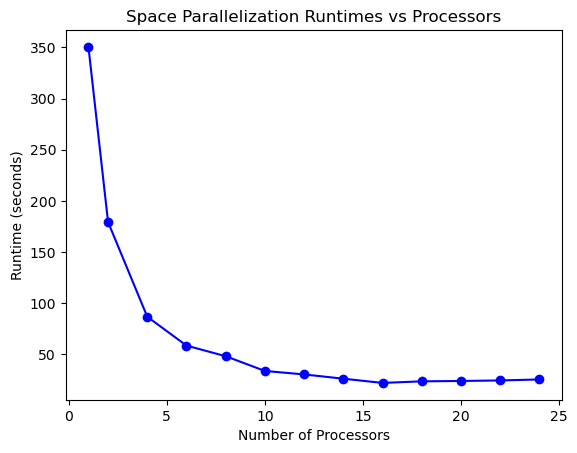

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
warnings.filterwarnings("ignore")
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('parareal/space.csv')

# Extract data from DataFrame
processors = df['Processors']
runtimes = df['Runtime']

# Plot the data
plt.plot(processors, runtimes, marker='o', linestyle='-', color='b')
plt.title('Space Parallelization Runtimes vs Processors')
plt.xlabel('Number of Processors')
plt.ylabel('Runtime (seconds)')
plt.grid(False)
plt.show()

In [9]:
df['Runtime']

0     350.5000
1     179.2500
2      86.6250
3      58.4200
4      44.0125
5      33.6050
6      28.2080
7      21.0360
8      21.9060
9      23.4560
10     23.8120
11     24.3240
12     25.2891
Name: Runtime, dtype: float64

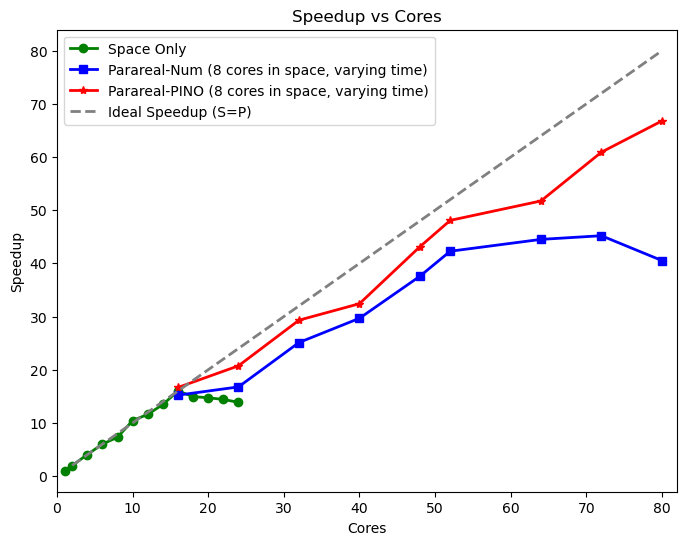

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
warnings.filterwarnings("ignore")

# Calculate speedup
df = pd.read_csv('parareal/space.csv')
dd = pd.read_csv('parareal/space_time_num.csv')
dp = pd.read_csv('parareal/space_time_pinn.csv')

df['Speedup'] = df['Runtime'][0] / df['Runtime']
dd['Speedup'] = df['Runtime'][0] / dd['Runtime']
dp['Speedup'] = df['Runtime'][0] / dp['Runtime']

cores = [num for num in range(2, 81, 2)]
# Plot
plt.figure(figsize=(8, 6))
plt.plot(df['Processors'], df['Speedup'], marker='o', linestyle='-', linewidth=2, color='green', label='Space Only')
plt.plot(dd['Processors'], dd['Speedup'], marker='s', linestyle='-', linewidth=2, color='blue', label='Parareal-Num (8 cores in space, varying time)')
plt.plot(dp['Processors'], dp['Speedup'], marker='*', linestyle='-', linewidth=2, color='red', label='Parareal-PINO (8 cores in space, varying time)')
plt.plot(cores, cores, linestyle='--', color='gray', linewidth=2, label='Ideal Speedup (S=P)')
plt.title('Speedup vs Cores')
plt.xlim(0, 82)
plt.xlabel('Cores')
plt.ylabel('Speedup')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
16
24
32
40
48
56
64
72


# Parareal

In [ ]:
# Run Time - Only Parareal for different number of cores
import subprocess

result = subprocess.run(['python3', 'parareal/run_parareal.py'], capture_output=True, text=True)
print(result.stdout)
print(result.stderr)

# Add time for he PINO

...................................
Number of Workers: 2, Runtime(NUM): 17.375534772872925 seconds
...................................
Number of Workers: 4, Runtime(NUM): 9.577127695083618 seconds
...................................
Number of Workers: 6, Runtime(NUM): 7.089229106903076 seconds
...................................
Number of Workers: 8, Runtime(NUM): 5.848342657089233 seconds
...................................
Number of Workers: 10, Runtime(NUM): 5.1248438358306885 seconds
...................................
Number of Workers: 12, Runtime(NUM): 4.668665409088135 seconds
Done
...................................
Number of Workers: 2, Runtime (ML): 9.584312915802002 seconds
...................................
Number of Workers: 4, Runtime (ML): 7.097478151321411 seconds
...................................
Number of Workers: 6, Runtime (ML): 5.846841335296631 seconds
...................................
Number of Workers: 8, Runtime (ML): 5.095785617828369 seconds
...........

In [ ]:
# Run Space-Time Parareal for different number of cores
import subprocess

result = subprocess.run(['python3', 'parareal/run_parareal_st.py'], capture_output=True, text=True)
print(result.stdout)
print(result.stderr)

...................................
Number of Workers: 2, Runtime(NUM): 12.352976560592651 seconds
...................................
Number of Workers: 4, Runtime(NUM): 7.078821659088135 seconds
...................................
Number of Workers: 6, Runtime(NUM): 5.441121339797974 seconds
...................................
Number of Workers: 8, Runtime(NUM): 4.605333089828491 seconds
...................................
Number of Workers: 10, Runtime(NUM): 4.118382930755615 seconds
...................................
Number of Workers: 12, Runtime(NUM): 3.8191452026367188 seconds
Done
...................................
Number of Workers: 2, Runtime (ML): 5.828684329986572 seconds
...................................
Number of Workers: 4, Runtime (ML): 4.5661749839782715 seconds
...................................
Number of Workers: 6, Runtime (ML): 3.9663619995117188 seconds
...................................
Number of Workers: 8, Runtime (ML): 3.588926076889038 seconds
.........

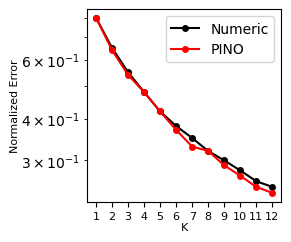

In [19]:
from pylab import rcParams
def read_convergence_values_from_file(filename):
    with open(filename, 'r') as file:
        convergence_values = [float(line.strip()) for line in file]
    return convergence_values


fs = 8
rcParams['figure.figsize'] = 2.5, 2.5

convergence_values = read_convergence_values_from_file(filename='parareal/convergence.txt')
convergence_values_ml = read_convergence_values_from_file(filename='parareal/convergence_ml.txt')
iterations = list(range(1, len(convergence_values) + 1))

plt.semilogy(iterations, convergence_values, 'k-o',
             label='Numeric', markersize=fs/2)
plt.semilogy(iterations, convergence_values_ml,
             'r-o', label='PINO', markersize=fs/2)
plt.xlabel('K', fontsize=fs, labelpad=0.5)
plt.ylabel('Normalized Error', fontsize=fs, labelpad=0.5)
plt.xticks(iterations, fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid(False)
plt.legend()
plt.gcf().savefig("parareal_convergence.pdf", bbox_inches='tight')
plt.show()

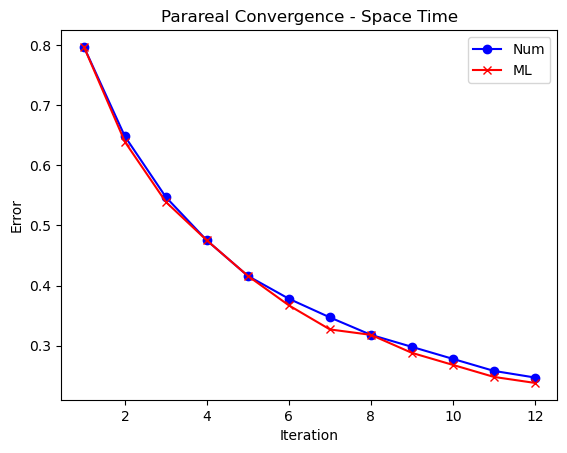

In [8]:
# Space-Time (TODO: change duplicatiof code (LAZY))
from parareal.convergence import plot_parareal_convergence_st
plot_parareal_convergence_st()

In [10]:
from parareal.convergence import read_convergence_values_from_file

convergence_values = read_convergence_values_from_file(filename='parareal/convergence.txt')
convergence_values_ml = read_convergence_values_from_file(filename='parareal/convergence_ml.txt')

convergence_values_st = read_convergence_values_from_file(filename='parareal/convergence_st.txt')
convergence_values_ml_st = read_convergence_values_from_file(filename='parareal/convergence_ml_st.txt')

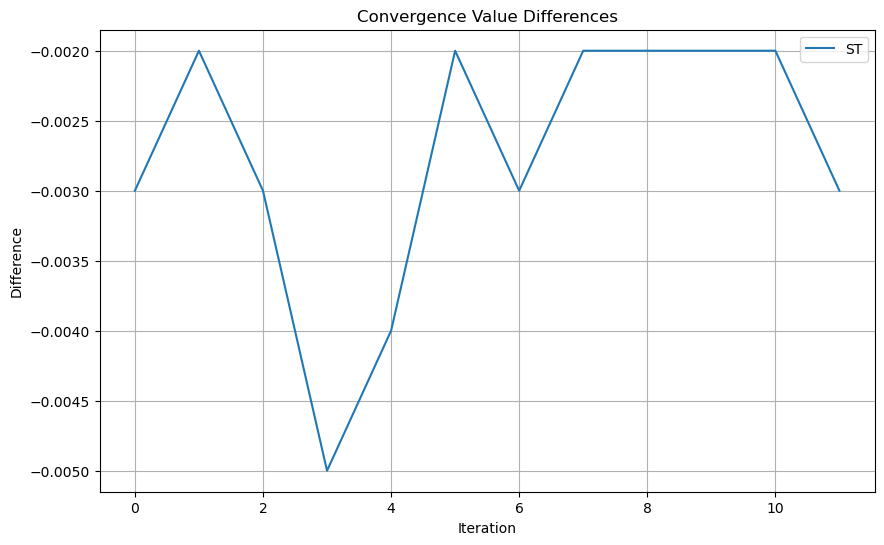

In [13]:
# Calculate the differences
difference_st = [cv_ml - cv for cv_ml, cv in zip(convergence_values_st, convergence_values)]
difference_ml_st = [cv_ml_st - cv_st for cv_ml_st, cv_st in zip(convergence_values_ml_st, convergence_values_ml)]

# Plotting
plt.figure(figsize=(10, 6))

# Plot the differences
plt.plot(difference_st, label='ST')
# plt.plot(difference_ml_st, label='ML with ST')

# Customize the plot
plt.title('Convergence Value Differences')
plt.xlabel('Iteration')
plt.ylabel('Difference')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()